## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.metrics import rmse, r2_score

random_state = 42
np.random.seed(random_state)

## Load data

In [3]:
receivals = pd.read_csv("data/kernel/receivals.csv")
purchase_orders = pd.read_csv("./data/kernel/purchase_orders.csv")

print(f"Receivals Shape: {receivals.shape}")
print(f"Purchase Orders Shape: {purchase_orders.shape}")


Receivals Shape: (122590, 10)
Purchase Orders Shape: (33171, 12)


In [4]:
receivals["date_arrival"] = (
    pd.to_datetime(receivals["date_arrival"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

In [5]:
purchase_orders["delivery_date"] = (
    pd.to_datetime(purchase_orders["delivery_date"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

purchase_orders["created_date_time"] = (
    pd.to_datetime(purchase_orders["created_date_time"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

purchase_orders["modified_date_time"] = (
    pd.to_datetime(purchase_orders["modified_date_time"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

In [6]:
merged_df = receivals.merge(
    purchase_orders,
    how="left",
    on=["purchase_order_id", "purchase_order_item_no"],
)

print(f"Merged DataFrame Shape: {merged_df.shape}")
merged_df.head()

Merged DataFrame Shape: (122590, 20)


,rm_id,product_id_x,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id,quantity,delivery_date,product_id_y,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status
0,365.0,91900143.0,208545.0,10.0,1,NaN,2004-06-15,Completed,11420.0,52062,1975000.0,2004-12-30,91900143.0,1.0,2004-01-13,2005-01-12,40.0,KG,2.0,Closed
1,365.0,91900143.0,208545.0,10.0,2,NaN,2004-06-15,Completed,13760.0,52062,1975000.0,2004-12-30,91900143.0,1.0,2004-01-13,2005-01-12,40.0,KG,2.0,Closed
2,365.0,91900143.0,208490.0,10.0,1,NaN,2004-06-15,Completed,11281.0,50468,1500000.0,2004-12-30,91900143.0,1.0,2004-01-09,2005-01-12,40.0,KG,2.0,Closed
3,365.0,91900143.0,208490.0,10.0,2,NaN,2004-06-15,Completed,13083.0,50468,1500000.0,2004-12-30,91900143.0,1.0,2004-01-09,2005-01-12,40.0,KG,2.0,Closed
4,379.0,91900296.0,210435.0,20.0,1,NaN,2004-06-15,Completed,23910.0,52577,125000.0,2004-06-29,91900296.0,1.0,2004-06-24,2005-01-12,40.0,KG,2.0,Closed


## Exploratory analysis

- Analyze the relationship between ordered quantity and received weight
- Delivery timing, target_date - delivery_date, avg, mean, before delivery_date, on-time, late delivery

In [7]:
# def analyze_overlap(df1, df2, key1, key2, label):
#     """Generic function to analyze ID overlaps between two datasets."""
#     ids_1 = set(df1[key1].dropna().unique())
#     ids_2 = set(df2[key2].dropna().unique())
#     overlap = ids_1 & ids_2

#     print(f"{label} overlap analysis:")
#     print(f"- {label} IDs in first dataset: {len(ids_1):,}")
#     print(f"- {label} IDs in second dataset: {len(ids_2):,}")
#     print(f"- Overlapping {label} IDs: {len(overlap):,}")
#     coverage = (len(overlap) / len(ids_1) * 100) if ids_1 else 0
#     print(f"- Coverage: {coverage:.1f}% of the first dataset has matches\n")


# # Analyze purchase order overlap
# analyze_overlap(
#     receivals,
#     purchase_orders,
#     key1="purchase_order_id",
#     key2="purchase_order_id",
#     label="Purchase Order",
# )

# # Analyze product overlap
# analyze_overlap(
#     receivals, purchase_orders, key1="product_id", key2="product_id", label="Product"
# )


## Feature engineering

- missing values
- outlier detection
- feature extraction
- data splitting

In [8]:
merged_df

,rm_id,product_id_x,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id,quantity,delivery_date,product_id_y,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status
0,365.0,91900143.0,208545.0,10.0,1,NaN,2004-06-15,Completed,11420.0,52062,1975000.0,2004-12-30,91900143.0,1.0,2004-01-13,2005-01-12,40.0,KG,2.0,Closed
1,365.0,91900143.0,208545.0,10.0,2,NaN,2004-06-15,Completed,13760.0,52062,1975000.0,2004-12-30,91900143.0,1.0,2004-01-13,2005-01-12,40.0,KG,2.0,Closed
2,365.0,91900143.0,208490.0,10.0,1,NaN,2004-06-15,Completed,11281.0,50468,1500000.0,2004-12-30,91900143.0,1.0,2004-01-09,2005-01-12,40.0,KG,2.0,Closed
3,365.0,91900143.0,208490.0,10.0,2,NaN,2004-06-15,Completed,13083.0,50468,1500000.0,2004-12-30,91900143.0,1.0,2004-01-09,2005-01-12,40.0,KG,2.0,Closed
4,379.0,91900296.0,210435.0,20.0,1,NaN,2004-06-15,Completed,23910.0,52577,125000.0,2004-06-29,91900296.0,1.0,2004-06-24,2005-01-12,40.0,KG,2.0,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122585,3421.0,91900160.0,328740.0,30.0,1,1178422.0,2024-12-19,Completed,1220.0,69879,100000.0,2024-12-30,91900160.0,7.0,2024-08-22,2025-02-19,40.0,KG,2.0,Closed
122586,2145.0,91900146.0,328740.0,20.0,2,1178431.0,2024-12-19,Completed,850.0,69879,130000.0,2024-12-30,91900146.0,7.0,2024-08-22,2025-02-19,40.0,KG,2.0,Closed
122587,3865.0,91900143.0,328740.0,10.0,3,1178432.0,2024-12-19,Completed,14170.0,69879,1300000.0,2024-12-30,91900143.0,9.0,2024-08-22,2025-02-19,40.0,KG,2.0,Closed
122588,3901.0,91901440.0,330334.0,10.0,1,1178427.0,2024-12-19,Completed,15020.0,72195,35000.0,2024-11-14,91901440.0,2.0,2024-11-15,2025-02-19,40.0,KG,2.0,Closed


### Missing values

In [9]:
def report_missing_values(df):
    missing_info = (
        df.isna()
        .sum()
        .to_frame("missing_count")
        .assign(
            total_rows=len(df),
            missing_pct=lambda x: x["missing_count"] / x["total_rows"] * 100,
        )
        .sort_values("missing_count", ascending=False)
    )

    print("Detailed missing value report:")
    print(missing_info)


report_missing_values(merged_df)
merged_df = merged_df.dropna(subset=["rm_id", "net_weight"])
report_missing_values(merged_df)


Detailed missing value report:
                        missing_count  total_rows  missing_pct
batch_id                        57825      122590    47.169427
modified_date_time                462      122590     0.376866
net_weight                         68      122590     0.055469
unit                               58      122590     0.047312
unit_id                            58      122590     0.047312
rm_id                              57      122590     0.046496
product_id_x                       57      122590     0.046496
product_id_y                       53      122590     0.043234
status_id                          53      122590     0.043234
created_date_time                  53      122590     0.043234
product_version                    53      122590     0.043234
quantity                           53      122590     0.043234
delivery_date                      53      122590     0.043234
purchase_order_item_no             53      122590     0.043234
purchase_order_id       

### Feature extraction

In [56]:
# fmt: off
merged_df = merged_df.copy()

merged_df['has_purchase_order'] = (merged_df['purchase_order_id'] > 0).astype(int)
merged_df['weight_quantity_ratio'] = np.where(
    merged_df["quantity"] > 0, 
    merged_df["net_weight"] / merged_df["quantity"],
    0,
)

merged_df['delivery_delay_days'] = (merged_df['date_arrival'] - merged_df['delivery_date']).dt.days
merged_df["order_to_receival_days"] = (merged_df["date_arrival"] - merged_df["created_date_time"]).dt.days


# Aggregate to daily level
daily = (
    merged_df.groupby(['rm_id', 'date_arrival'])
    .agg(
        net_weight=('net_weight', 'sum'),
        quantity=('quantity', 'sum'),
        weight_quantity_ratio=('weight_quantity_ratio', 'mean'),
        delivery_delay_days=('delivery_delay_days', 'mean'),
        order_to_receival_days=('order_to_receival_days', 'mean'),
        num_receivals=('net_weight', 'count'),
        purchase_orders=('has_purchase_order', 'sum'),
    )
    .reset_index()
).sort_values(["rm_id", "date_arrival"])
# fmt: on

In [57]:
def add_time_features(df):
    """Add calendar-based time features."""
    df["month"] = df["date_arrival"].dt.month
    df["week_of_year"] = df["date_arrival"].dt.isocalendar().week
    df["weekday"] = df["date_arrival"].dt.weekday
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
    df["year"] = df["date_arrival"].dt.year
    df["quarter"] = df["date_arrival"].dt.quarter
    return df


def create_grid(rm_ids, start_date, end_date):
    """
    Create a complete grid of rm_id and target_date combinations.
    """
    date_range = pd.date_range(start=start_date, end=end_date, freq="D")
    grid = (
        pd.MultiIndex.from_product(
            [rm_ids, date_range], names=["rm_id", "date_arrival"]
        ).to_frame(index=False)
        # .sort_values(["rm_id", "date_arrival"])
    )
    return grid


def calculate_targets(receivals_df, cutoff_date, end_date, target_dates):
    """
    Target calculation for all dates at once
    """
    future = receivals_df[
        (receivals_df["date_arrival"] > cutoff_date)
        & (receivals_df["date_arrival"] <= end_date)
    ]

    targets_list = []
    for target_date in target_dates:
        daily = (
            future[future["date_arrival"] <= target_date]
            .groupby("rm_id")["net_weight"]
            .sum()
            .reset_index()
        )
        daily.columns = ["rm_id", "target"]
        daily["target_date"] = target_date
        targets_list.append(daily)

    return pd.concat(targets_list, ignore_index=True)

In [62]:
def create_features(df):
    df_lst = []
    min_year = df["date_arrival"].dt.year.min()
    max_year = 2026

    for idx, group in df.groupby("rm_id"):
        lst = []
        for year in range(min_year, max_year):
            grid = create_grid([idx], f"{year}-01-02", f"{year}-12-31")
            grid = add_time_features(grid)
            lst.append(grid)
        year_df = pd.concat(lst, ignore_index=True)

        df_lst.append(year_df)
    features = pd.concat(df_lst, ignore_index=True)
    features = features.merge(df, on=["rm_id", "date_arrival"], how="left").fillna(0)
    # Statistical features

    # Time since last receival
    features["days_since_last"] = (
        features.groupby("rm_id")["date_arrival"].diff().dt.days.fillna(0)
    )

    for w in [60, 90, 180, 365]:
        features[f"avg_delivery_delay_{w}d"] = features.groupby("rm_id")[
            "delivery_delay_days"
        ].transform(lambda x: x.rolling(window=w, min_periods=1).mean())
        features[f"avg_order_to_receival_{w}d"] = features.groupby("rm_id")[
            "order_to_receival_days"
        ].transform(lambda x: x.rolling(window=w, min_periods=1).mean())
        features[f"avg_weight_quantity_ratio_{w}d"] = features.groupby("rm_id")[
            "weight_quantity_ratio"
        ].transform(lambda x: x.rolling(window=w, min_periods=1).mean())

    for w in [30, 60, 90, 180, 365]:
        features[f"rolling_net_weight_sum_{w}d"] = features.groupby("rm_id")[
            "net_weight"
        ].transform(lambda x: x.rolling(window=w, min_periods=1).sum())
        features[f"rolling_net_weight_avg_{w}d"] = features.groupby("rm_id")[
            "net_weight"
        ].transform(lambda x: x.rolling(window=w, min_periods=1).mean())

    for w in [30, 60, 90]:
        features[f"trend_{w}d"] = features[
            f"rolling_net_weight_avg_{w}d"
        ] - features.groupby("rm_id")[f"rolling_net_weight_avg_{w}d"].shift(w).rolling(
            window=w, min_periods=1
        ).mean().reset_index(level=0, drop=True)
        features[f"num_receivals_{w}d"] = features.groupby("rm_id")[
            "num_receivals"
        ].transform(lambda x: x.rolling(window=w, min_periods=1).sum())

    features["total_quantity"] = features.groupby("rm_id")["quantity"].cumsum()
    features["total_receivals"] = features.groupby("rm_id")["num_receivals"].cumsum()
    # features["total_purchase_orders"] = features.groupby("rm_id")[
    #     "purchase_orders"
    # ].cumsum()

    features = features[features.date_arrival.dt.month.isin([1, 2, 3, 4, 5])]

    # calculate net_weight target
    features["net_weight_target"] = features.groupby(["rm_id", "year"])[
        "net_weight"
    ].cumsum()
    return features


hist = create_features(daily)

In [24]:
daily.columns

Index(['rm_id', 'date_arrival', 'net_weight', 'quantity',
       'weight_quantity_ratio', 'delivery_delay_days',
       'order_to_receival_days'],
      dtype='object')

In [33]:
hist.describe()


,rm_id,date_arrival,month,week_of_year,weekday,is_weekend,year,quarter,net_weight,quantity,...,rolling_net_weight_avg_180d,trend_30d,num_receivals_30d,trend_60d,num_receivals_60d,trend_90d,num_receivals_90d,total_quantity,totel_receivals,net_weight_target
count,671118.000000,671118,671118.000000,671118.0,671118.000000,671118.000000,671118.000000,671118.000000,671118.000000,6.711180e+05,...,671118.000000,670886.000000,671118.000000,670856.000000,671118.000000,670826.000000,671118.000000,6.711180e+05,671118.000000,6.711180e+05
mean,2345.359606,2014-09-15 19:19:03.375680,3.024803,11.514217,2.998488,0.285541,2014.499093,1.405929,1010.309290,3.518514e+04,...,960.541186,-7.691666,2.234912,10.797200,4.481899,33.869790,6.778124,1.760230e+08,284.405345,7.546211e+04
min,342.000000,2004-01-02 00:00:00,1.000000,1.0,0.000000,0.000000,2004.000000,1.000000,0.000000,0.000000e+00,...,0.000000,-110446.141111,0.000000,-104314.223056,0.000000,-110593.480617,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,1875.000000,2009-03-17 00:00:00,2.000000,6.0,1.000000,0.000000,2009.000000,1.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,2159.000000,2014-09-16 00:00:00,3.000000,11.0,3.000000,0.000000,2014.500000,1.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.686295e+04,1.000000,0.000000e+00
75%,3142.000000,2020-03-17 00:00:00,4.000000,17.0,5.000000,1.000000,2020.000000,2.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.961620e+06,26.000000,0.000000e+00
max,4501.000000,2025-05-31 00:00:00,5.000000,53.0,6.000000,1.000000,2025.000000,2.000000,331850.000000,1.129997e+08,...,129360.011111,123848.480000,353.000000,118078.166667,671.000000,80677.533333,974.000000,2.350792e+10,23620.000000,2.036912e+07
std,1124.579158,NaN,1.418056,6.546683,2.000379,0.451672,6.345247,0.491071,9964.701181,9.440969e+05,...,6827.000200,2862.834938,15.141967,2464.347335,29.830834,2585.097152,44.651344,1.598418e+09,1589.073260,6.341922e+05


In [37]:
test_df.describe()

,rm_id,date_arrival,month,week_of_year,weekday,is_weekend,year,quarter,net_weight,quantity,...,rolling_net_weight_avg_180d,trend_30d,num_receivals_30d,trend_60d,num_receivals_60d,trend_90d,num_receivals_90d,total_quantity,totel_receivals,net_weight_target
count,30450.000000,30450,30450.000000,30450.0,30450.000000,30450.000000,30450.0,30450.000000,30450.0,30450.0,...,30450.000000,30450.000000,30450.000000,30450.000000,30450.000000,30450.000000,30450.000000,3.045000e+04,30450.000000,30450.0
mean,2345.359606,2025-03-17 12:00:00,3.026667,11.64,3.020000,0.286667,2025.0,1.406667,0.0,0.0,...,601.402603,-335.306442,0.087094,-700.100156,0.630673,-827.004665,1.662857,2.851681e+08,603.541872,0.0
min,342.000000,2025-01-02 00:00:00,1.000000,1.0,0.000000,0.000000,2025.0,1.000000,0.0,0.0,...,0.000000,-62503.074444,0.000000,-67662.836944,0.000000,-60597.812963,0.000000,5.050000e+02,1.000000,0.0
25%,1875.000000,2025-02-08 00:00:00,2.000000,6.0,1.000000,0.000000,2025.0,1.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+05,3.000000,0.0
50%,2159.000000,2025-03-17 12:00:00,3.000000,12.0,3.000000,0.000000,2025.0,1.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.118000e+06,21.000000,0.0
75%,3142.000000,2025-04-24 00:00:00,4.000000,17.0,5.000000,1.000000,2025.0,2.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.010562e+07,183.000000,0.0
max,4501.000000,2025-05-31 00:00:00,5.000000,22.0,6.000000,1.000000,2025.0,2.000000,0.0,0.0,...,56398.011111,3550.733333,77.000000,2058.591667,176.000000,11612.773827,295.000000,2.350792e+10,23620.000000,0.0
std,1124.596786,NaN,1.418692,6.193948,1.988231,0.452212,0.0,0.491220,0.0,0.0,...,3095.037215,2642.599724,1.449388,3790.702525,5.667453,4104.986341,11.628514,1.880732e+09,2421.546795,0.0


### Data splitting

In [63]:
train_df = hist[
    (hist.date_arrival.dt.year >= 2020) & (hist.date_arrival.dt.year <= 2023)
]
val_df = hist[hist.date_arrival.dt.year == 2024]
test_df = hist[hist.date_arrival.dt.year == 2025]

print(f"Train Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (122003, 47)
Validation Shape: (30653, 47)
Test Shape: (30450, 47)


In [66]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

cols_to_exclude = [
    "date_arrival",
    "net_weight",
    "net_weight_target",
    "quantity",
    "order_to_receival_days",
    "delivery_delay_days",
    "weight_quantity_ratio",
    "quantity",
    "num_receivals",
    "purchase_orders",
]
X_train = train_df.drop(columns=cols_to_exclude).copy()
y_train = train_df["net_weight_target"]

X_val = val_df.drop(columns=cols_to_exclude).copy()
y_val = val_df["net_weight_target"]
X_test = test_df.drop(columns=cols_to_exclude).copy()


def pinball_loss_p20(y_true, y_pred, q: float = 0.20):
    diff = y_true - y_pred
    return np.mean(np.maximum(q * diff, (q - 1) * diff))


# Custom P20 evaluation metric
def pinball_loss_p20_metric(preds, dtrain):
    """
    Custom P20 (20th percentile) pinball loss for XGBoost
    """
    labels = dtrain.get_label()
    alpha = 0.20
    residual = labels - preds
    # loss = np.where(residual >= 0, alpha * residual, (alpha - 1) * residual)
    loss = np.maximum(alpha * residual, (alpha - 1) * residual)
    return "p20", float(np.mean(loss))


# XGBoost parameters
params = {
    "max_depth": 4,
    "min_child_weight": 5,
    "eta": 0.05,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "reg_alpha": 0.1,
    "reg_lambda": 5,
    "objective": "reg:quantileerror",  # Built-in quantile regression
    "quantile_alpha": 0.20,  # 20th percentile
    "tree_method": "hist",
    # 'eval_metric': ['mae', 'rmse']
}

# Convert to DMatrix for custom objective
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Train model
evals = [(dtrain, "train"), (dval, "val")]
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100,
    evals_result=evals_result,
    custom_metric=pinball_loss_p20_metric,
)


[0]	train-quantile:18169.37344	train-p20:18169.37109	val-quantile:18016.05006	val-p20:18016.04883
[100]	train-quantile:10340.07652	train-p20:10340.07715	val-quantile:9125.42931	val-p20:9125.42969
[200]	train-quantile:6173.92688	train-p20:6173.92725	val-quantile:5206.75875	val-p20:5206.75879
[300]	train-quantile:4866.64048	train-p20:4866.64062	val-quantile:4435.78043	val-p20:4435.78076
[400]	train-quantile:4504.79416	train-p20:4504.79443	val-quantile:4254.95920	val-p20:4254.95947
[500]	train-quantile:4248.80528	train-p20:4248.80566	val-quantile:4110.00770	val-p20:4110.00781
[600]	train-quantile:4048.76262	train-p20:4048.76269	val-quantile:4007.91706	val-p20:4007.91699
[700]	train-quantile:3875.77544	train-p20:3875.77563	val-quantile:3978.71178	val-p20:3978.71167
[800]	train-quantile:3656.79551	train-p20:3656.79541	val-quantile:3795.23677	val-p20:3795.23682
[868]	train-quantile:3355.45420	train-p20:3355.45435	val-quantile:3957.55003	val-p20:3957.55005


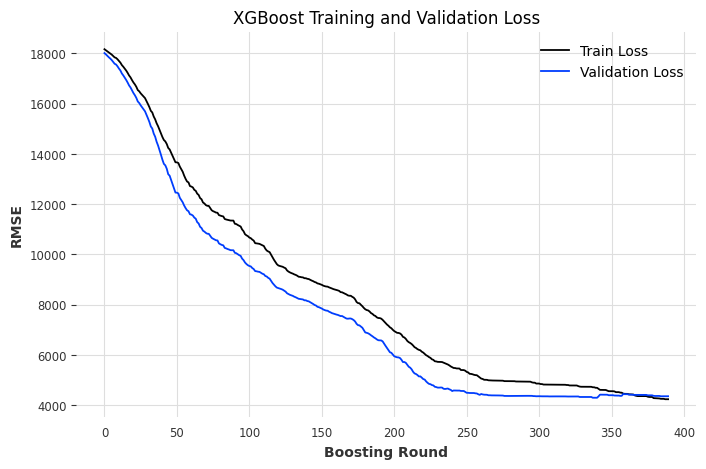

In [65]:
# Get evaluation results

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(evals_result["train"]["p20"], label="Train Loss")
plt.plot(evals_result["val"]["p20"], label="Validation Loss")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("XGBoost Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# Make predictions on BOTH train and validation
train_predictions = model.predict(dtrain)
val_predictions = model.predict(dval)

test_predictions = model.predict(dtest)
test_predictions = np.maximum(test_predictions, 0)

# Calculate metrics for TRAINING
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_p20_loss = pinball_loss_p20(y_train, train_predictions)

# Calculate metrics for VALIDATION
val_mae = mean_absolute_error(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_p20_loss = pinball_loss_p20(y_val, val_predictions)

# Display side-by-side comparison
print(f"\nTRAINING Performance:")
print(f"   MAE:      {train_mae:,.2f} kg")
print(f"   RMSE:     {train_rmse:,.2f} kg")
print(f"   P20 Loss: {train_p20_loss:,.2f} kg")

print(f"\nVALIDATION Performance:")
print(f"   MAE:      {val_mae:,.2f} kg")
print(f"   RMSE:     {val_rmse:,.2f} kg")
print(f"   P20 Loss: {val_p20_loss:,.2f} kg")


TRAINING Performance:
   MAE:      15,271.28 kg
   RMSE:     169,677.20 kg
   P20 Loss: 3,360.81 kg

VALIDATION Performance:
   MAE:      15,069.96 kg
   RMSE:     102,758.32 kg
   P20 Loss: 4,346.81 kg


In [41]:
print("1. XGBoost Feature Importance Analysis...")

# Get feature importance from XGBoost
feature_importance = model.get_score(importance_type="weight")
feature_names = [f for f in feature_importance.keys() if f != "rm_id"]
importance_values = [feature_importance[f] for f in feature_names]

# Sort by importance
sorted_features = sorted(
    zip(feature_names, importance_values), key=lambda x: x[1], reverse=True
)

print("\n📊 Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(sorted_features[:10]):
    print(f"   {i + 1:2}. {feature:20}: {importance:8.0f}")

print("\n📊 Top 10 Least Important Features:")
for i, (feature, importance) in enumerate(sorted_features[-10:]):
    print(f"   {i + 1:2}. {feature:20}: {importance:8.0f}")

1. XGBoost Feature Importance Analysis...

📊 Top 10 Most Important Features:
    1. rolling_net_weight_sum_180d:      722
    2. week_of_year        :      717
    3. avg_weight_quantity_ratio_180d:      676
    4. rolling_net_weight_sum_90d:      448
    5. total_quantity      :      402
    6. avg_delivery_delay_180d:      382
    7. month               :      380
    8. avg_order_to_receival_180d:      376
    9. avg_weight_quantity_ratio_365d:      322
   10. trend_60d           :      270

📊 Top 10 Least Important Features:
    1. avg_delivery_delay_90d:       51
    2. quarter             :       50
    3. rolling_net_weight_avg_30d:       41
    4. avg_order_to_receival_60d:       38
    5. avg_weight_quantity_ratio_30d:       37
    6. num_receivals_60d   :       33
    7. avg_weight_quantity_ratio_60d:       24
    8. rolling_net_weight_avg_60d:       22
    9. days_since_last     :       12
   10. is_weekend          :       11


In [42]:
prediction_mapping = pd.read_csv("./data/prediction_mapping.csv")

prediction_mapping["forecast_end_date"] = (
    pd.to_datetime(prediction_mapping["forecast_end_date"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)
prediction_mapping = prediction_mapping.sort_values(["rm_id", "forecast_end_date"])

test_df = test_df.copy()
test_df["predicted_weight"] = test_predictions
test_df["predicted_weight"] = test_df["predicted_weight"].clip(lower=0)
test_df["predicted_weight"] = test_df.groupby("rm_id")["predicted_weight"].cummax()

df_submission = (
    prediction_mapping.merge(
        test_df,
        left_on=["rm_id", "forecast_end_date"],
        right_on=["rm_id", "date_arrival"],
        how="left",
    )
    .rename(columns={"net_weight_cumsum": "predicted_weight"})
    .sort_values("ID")
)
df_submission.fillna(0, inplace=True)
df_submission[["ID", "predicted_weight"]].to_csv(f"submission_.csv", index=False)

In [20]:
test_df["test"] = test_df.groupby("rm_id")["predicted_weight"].cumsum()

In [43]:
# ============================================================================
# PARAMETER GRID SEARCH
# ============================================================================
print("\n" + "=" * 70)
print("PARAMETER GRID SEARCH")
print("=" * 70)

import itertools

# Define parameter grid
param_grid = {
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 3, 5],
    "eta": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [1, 5, 10],
}

# Create all combinations
keys = param_grid.keys()
values = param_grid.values()
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total parameter combinations: {len(param_combinations)}")
print("This might take a while...\n")

# Store results
grid_search_results = []

# Test a subset of combinations (for speed)
import random

random.seed(42)
sample_size = min(20, len(param_combinations))  # Test 20 random combinations
param_sample = random.sample(param_combinations, sample_size)

print(f"Testing {sample_size} random parameter combinations...")

for i, params in enumerate(param_sample):
    print(f"\n{'=' * 70}")
    print(f"Combination {i + 1}/{sample_size}")
    print(f"{'=' * 70}")
    print(f"Parameters: {params}")

    # Add fixed parameters
    full_params = {
        **params,
        "objective": "reg:quantileerror",
        "quantile_alpha": 0.20,
        "tree_method": "hist",
    }

    # Train model
    try:
        evals_result_temp = {}
        model_temp = xgb.train(
            full_params,
            dtrain,
            num_boost_round=500,  # Reduced for speed
            evals=[(dtrain, "train"), (dval, "val")],
            early_stopping_rounds=50,
            verbose_eval=False,
            evals_result=evals_result_temp,
            custom_metric=pinball_loss_p20_metric,
        )

        # Evaluate
        val_pred_temp = model_temp.predict(dval)
        val_p20_temp = pinball_loss_p20(y_val, val_pred_temp)

        # Store results
        grid_search_results.append(
            {
                "params": params,
                "val_p20": val_p20_temp,
                "best_iteration": model_temp.best_iteration,
            }
        )

        print(f"✓ Val P20 Loss: {val_p20_temp:,.2f} kg")
        print(f"  Best iteration: {model_temp.best_iteration}")

    except Exception as e:
        print(f"✗ Error: {e}")
        continue

# ============================================================================
# ANALYZE GRID SEARCH RESULTS
# ============================================================================
print("\n" + "=" * 70)
print("GRID SEARCH RESULTS")
print("=" * 70)

# Sort by validation P20 loss
grid_search_results.sort(key=lambda x: x["val_p20"])

# Display top 10 results
print("\n📊 Top 10 Parameter Combinations:")
for i, result in enumerate(grid_search_results[:10]):
    print(f"\n{i + 1}. Val P20 Loss: {result['val_p20']:,.2f} kg")
    print(f"   Parameters:")
    for key, value in result["params"].items():
        print(f"     {key}: {value}")
    print(f"   Best iteration: {result['best_iteration']}")

# Get best parameters
best_params = grid_search_results[0]["params"]
best_val_p20 = grid_search_results[0]["val_p20"]

print("\n" + "=" * 70)
print("🏆 BEST PARAMETERS FOUND")
print("=" * 70)
print(f"\nBest Val P20 Loss: {best_val_p20:,.2f} kg")
print("\nBest Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# ============================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# ============================================================================
print("\n" + "=" * 70)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("=" * 70)

# Combine best parameters with fixed parameters
final_params = {
    **best_params,
    "objective": "reg:quantileerror",
    "quantile_alpha": 0.20,
    "tree_method": "hist",
}

print("\nFinal parameters:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

# Train final model
evals_result = {}
model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=100,
    evals_result=evals_result,
    custom_metric=pinball_loss_p20_metric,
)

print(f"\n✓ Final model trained!")
print(f"  Best iteration: {model.best_iteration}")

# ============================================================================
# STEP 3: EVALUATE ON TRAIN AND VALIDATION
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3: TRAIN vs VALIDATION PERFORMANCE")
print("=" * 70)

# Make predictions on BOTH train and validation
train_predictions = model.predict(dtrain)
val_predictions = model.predict(dval)

# Calculate metrics for TRAINING
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_p20_loss = pinball_loss_p20(y_train, train_predictions)

# Calculate metrics for VALIDATION
val_mae = mean_absolute_error(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_p20_loss = pinball_loss_p20(y_val, val_predictions)

# Display side-by-side comparison
print(f"\n📊 TRAINING Performance:")
print(f"   MAE:      {train_mae:,.2f} kg")
print(f"   RMSE:     {train_rmse:,.2f} kg")
print(f"   P20 Loss: {train_p20_loss:,.2f} kg")

print(f"\n📊 VALIDATION Performance:")
print(f"   MAE:      {val_mae:,.2f} kg")
print(f"   RMSE:     {val_rmse:,.2f} kg")
print(f"   P20 Loss: {val_p20_loss:,.2f} kg ⭐ (Competition Metric)")

# Calculate gaps
mae_gap = val_mae - train_mae
mae_gap_pct = (mae_gap / train_mae) * 100
rmse_gap = val_rmse - train_rmse
p20_gap = val_p20_loss - train_p20_loss
p20_gap_pct = (p20_gap / train_p20_loss) * 100

print(f"\n📈 TRAIN-VAL GAP (Overfitting Check):")
print(f"   MAE Gap:      {mae_gap:,.2f} kg ({mae_gap_pct:+.1f}%)")
print(f"   RMSE Gap:     {rmse_gap:,.2f} kg")
print(f"   P20 Gap:      {p20_gap:,.2f} kg ({p20_gap_pct:+.1f}%)")

# Overfitting diagnosis
print(f"\n🔍 Diagnosis:")
if p20_gap_pct < 10:
    print(f"   ✅ NO OVERFITTING - Gap is only {p20_gap_pct:.1f}%")
    print(f"      Model generalizes well!")
elif p20_gap_pct < 30:
    print(f"   ⚠️  SLIGHT OVERFITTING - Gap is {p20_gap_pct:.1f}%")
    print(f"      Acceptable but could be improved")
else:
    print(f"   ❌ SIGNIFICANT OVERFITTING - Gap is {p20_gap_pct:.1f}%")
    print(f"      Model memorizing training data!")

# Analyze prediction bias
train_under = (train_predictions < y_train).mean() * 100
train_over = (train_predictions > y_train).mean() * 100
val_under = (val_predictions < y_val).mean() * 100
val_over = (val_predictions > y_val).mean() * 100

print(f"\n📉 Prediction Bias:")
print(f"   TRAIN:")
print(f"      Under-predictions: {train_under:.1f}%")
print(f"      Over-predictions:  {train_over:.1f}%")
print(f"   VALIDATION:")
print(f"      Under-predictions: {val_under:.1f}%")
print(f"      Over-predictions:  {val_over:.1f}%")
print(f"   (p20 target: ~20% under-predictions)")

# Example predictions comparison
print(f"\n📋 Example Predictions (first 10 validation rows):")
comparison = pd.DataFrame(
    {
        "rm_id": val_unified["rm_id"].iloc[:10]
        if "val_unified" in locals()
        else val_df["rm_id"].iloc[:10],
        "date": (
            val_unified["date_arrival"].iloc[:10].dt.date
            if "val_unified" in locals()
            else val_df["date_arrival"].iloc[:10].dt.date
        ),
        "actual": y_val[:10],
        "predicted": val_predictions[:10],
        "error": val_predictions[:10] - y_val[:10],
    }
)
print(comparison.to_string(index=False))

# Clip negative predictions
val_predictions = np.maximum(val_predictions, 0)

# Continue with rest of the training code (monotonicity, test predictions, etc.)
# ============================================================================
# STEP 4: ENFORCE MONOTONICITY
# ============================================================================
print("\n" + "=" * 70)
print("STEP 4: ENFORCE MONOTONICITY")
print("=" * 70)

val_check = val_df[["rm_id", "date_arrival"]].copy()
val_check["predicted"] = val_predictions

# Enforce monotonicity
for rm_id in val_check["rm_id"].unique():
    mask = val_check["rm_id"] == rm_id
    val_check.loc[mask, "predicted"] = (
        val_check.loc[mask].sort_values("date_arrival")["predicted"].cummax().values
    )

val_predictions = val_check["predicted"].values
print("✓ Monotonicity enforced")

# Recalculate p20 after monotonicity fix
p20_loss_fixed = pinball_loss_p20(y_val, val_predictions)
print(f"  P20 Loss (before fix): {val_p20_loss:,.2f} kg")
print(f"  P20 Loss (after fix):  {p20_loss_fixed:,.2f} kg")

# ============================================================================
# STEP 5: PREDICT TEST DATA
# ============================================================================
print("\n" + "=" * 70)
print("STEP 5: PREDICT ON TEST DATA (2025)")
print("=" * 70)

dtest = xgb.DMatrix(X_test)
test_predictions = model.predict(dtest)

# Clip negatives
test_predictions = np.maximum(test_predictions, 0)

# Enforce monotonicity
test_df_pred = test_df[["ID", "rm_id", "date_arrival"]].copy()
test_df_pred["predicted_weight"] = test_predictions

for rm_id in test_df_pred["rm_id"].unique():
    mask = test_df_pred["rm_id"] == rm_id
    test_df_pred.loc[mask, "predicted_weight"] = (
        test_df_pred.loc[mask]
        .sort_values("date_arrival")["predicted_weight"]
        .cummax()
        .values
    )

print("✓ Test predictions made with monotonicity enforced")

print(f"\n📊 Test Prediction Statistics:")
print(f"  Min:    {test_df_pred['predicted_weight'].min():,.2f} kg")
print(f"  Max:    {test_df_pred['predicted_weight'].max():,.2f} kg")
print(f"  Mean:   {test_df_pred['predicted_weight'].mean():,.2f} kg")
print(f"  Median: {test_df_pred['predicted_weight'].median():,.2f} kg")

# ============================================================================
# STEP 6: CREATE SUBMISSION
# ============================================================================
print("\n" + "=" * 70)
print("STEP 6: CREATE SUBMISSION FILE")
print("=" * 70)

submission = pd.DataFrame(
    {"ID": test_df_pred["ID"], "predicted_weight": test_df_pred["predicted_weight"]}
)

submission = submission.sort_values("ID").reset_index(drop=True)

submission_file = "submission_p20_gridsearch_optimized.csv"
submission.to_csv(submission_file, index=False)

print(f"\n✓ Submission saved to: {submission_file}")
print(f"  Rows: {len(submission):,}")
print(f"\n📋 First 10 rows:")
print(submission.head(10).to_string(index=False))

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("✅ GRID SEARCH OPTIMIZED MODEL COMPLETE!")
print("=" * 70)
print(f"""
Summary:
  ✓ Grid search tested {len(param_sample)} parameter combinations
  ✓ Best parameters found and applied
  ✓ Model trained with p20 quantile regression (20th percentile)
  ✓ Trained on {len(X_train):,} examples (2021-2023)
  ✓ Validated on {len(X_val):,} examples (2024)
  ✓ Predictions made for {len(X_test):,} examples (2025)
  ✓ Monotonicity enforced
  
Performance:
  TRAINING:
    MAE:  {train_mae:,.2f} kg
    P20:  {train_p20_loss:,.2f} kg
  
  VALIDATION:
    MAE:  {val_mae:,.2f} kg
    P20:  {p20_loss_fixed:,.2f} kg ⭐
  
  Overfitting Gap: {p20_gap_pct:.1f}% {"✅" if p20_gap_pct < 10 else "⚠️" if p20_gap_pct < 30 else "❌"}
  
Best Parameters Found:
  max_depth: {best_params.get("max_depth", "N/A")}
  min_child_weight: {best_params.get("min_child_weight", "N/A")}
  eta: {best_params.get("eta", "N/A")}
  subsample: {best_params.get("subsample", "N/A")}
  colsample_bytree: {best_params.get("colsample_bytree", "N/A")}
  reg_alpha: {best_params.get("reg_alpha", "N/A")}
  reg_lambda: {best_params.get("reg_lambda", "N/A")}
  
What p20 means:
  - Predicts the 20th percentile (conservative estimate)
  - Aims to under-predict only ~20% of the time
  - Good for inventory management (avoid stockouts)
  
Submission file: {submission_file}
""")

# ============================================================================
# ADDITIONAL ANALYSIS: FEATURE IMPORTANCE
# ============================================================================
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importance from the best model
feature_importance = model.get_score(importance_type="weight")
feature_names = [f for f in feature_importance.keys() if f != "rm_id"]
importance_values = [feature_importance[f] for f in feature_names]

# Sort by importance
sorted_features = sorted(
    zip(feature_names, importance_values), key=lambda x: x[1], reverse=True
)

print("\n📊 Top 15 Most Important Features:")
for i, (feature, importance) in enumerate(sorted_features[:15]):
    print(f"   {i + 1:2}. {feature:25}: {importance:8.0f}")

# ============================================================================
# SAVE MODEL AND RESULTS
# ============================================================================
print("\n" + "=" * 70)
print("SAVING MODEL AND RESULTS")
print("=" * 70)

# Save the model
model_file = "xgb_model_p20_gridsearch.pkl"
import pickle

with open(model_file, "wb") as f:
    pickle.dump(model, f)

# Save grid search results
results_file = "grid_search_results.csv"
results_df = pd.DataFrame(grid_search_results)
results_df.to_csv(results_file, index=False)

print(f"✓ Model saved to: {model_file}")
print(f"✓ Grid search results saved to: {results_file}")
print(f"✓ Submission file: {submission_file}")

print(f"\n🎯 Ready for submission!")
print(f"   Submit file: {submission_file}")
print(f"   Model file: {model_file}")
print(f"   Results file: {results_file}")


PARAMETER GRID SEARCH
Total parameter combinations: 2187
This might take a while...

Testing 20 random parameter combinations...

Combination 1/20
Parameters: {'max_depth': 4, 'min_child_weight': 3, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 1.0, 'reg_lambda': 1}
✓ Val P20 Loss: 4,062.61 kg
  Best iteration: 166

Combination 2/20
Parameters: {'max_depth': 4, 'min_child_weight': 1, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 1}
✓ Val P20 Loss: 4,977.66 kg
  Best iteration: 320

Combination 3/20
Parameters: {'max_depth': 6, 'min_child_weight': 3, 'eta': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0, 'reg_lambda': 5}
✓ Val P20 Loss: 3,930.76 kg
  Best iteration: 279

Combination 4/20
Parameters: {'max_depth': 6, 'min_child_weight': 3, 'eta': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 5}
✓ Val P20 Loss: 6,785.28 kg
  Best iteration: 499

Combination 5/20
Parameters:

KeyError: "['ID'] not in index"